# QR code detector

QR codes, like AruCo markers, are another type of specifically designed object, used to store information and describe 3D space. You can find QR codes almost everywhere, from food packages to museums and robotized factories.

In this recipe, we will understand how to detect QR codes and remove perspective distortions to get a canonical view of the codes. This task may sound easy to complete, but it requires a lot of OpenCV functionality. 

If you look at any QR code, you'll see that it has special markers on each of its corners. These markers are just white and black squares inside of each other. So, to detect and localize the QR code, we need to detect these three special markers. We can do that with `cv2.findContours`. We need to exploit the information inside of the central black square; there are no other objects, and consequently, no other contours. The next white square contains only one contour. And again, the next black square contains only two contours. You may remember that `cv2.findContours` can return a hierarchy of contours on the image. We just need to find the described structure of the nested contours. Also, our markers have square shapes, and we can use this information to further exclude false positives. We can approximate our contours with a fewer number of points with the `cv2.approxPolyDP` function. Our contours can be approximated with a four vertex polygon with high accuracy.

After we've found the markers and their contours, we should decide their mutual location. In other words, we should find out whether there are bottom-left and upper-right markers, and whether there is an upper-left one. Bottom-left and upper-right markers lie on the diagonal, so they have the largest distance between them. Using this fact, we can choose the diagonal markers and the upper-left one. Then, we need to figure out which of our diagonal markers is bottom-left. To do this, we find the middle point of the QR code, and see what rotation (clockwise or counter-clockwise) we should perform to match a vector from the middle point to the upper-left corner and a vector from the middle point to one of the diagonal markers. This can be done by finding a sign of a $Z$ projection of the cross product of the vectors.

Now we know all about the three marked corners, and we need to find the last corner of the QR code. To do it, we find an intersection between the lines formed by the sides of the outer squares of diagonal markers. These facts give us two linear equations, with two variables, the $x$ and $y$ coordinates of the intersection point. `cv2.solve` can tackle this issue and find the solution of our linear system.

At this point, we have all four outer corners of the QR code, and we need to eliminate perspective transformations and get a canonical view of the code. This can be done by applying `cv2.warpPerspective`.


In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S04\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s04\env

d:\html_doc\program\opencv\packt\s04\env\lib\site-packages
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S04\env


In [2]:
# Implement a function which finds the intersection point of two lines
def intersect(l1, l2):
    delta = np.array([l1[1] - l1[0], l2[1] - l2[0]]).astype(np.float32)
    
    delta = 1 / delta
    delta[:, 0] *= -1
    
    b = np.matmul(delta, np.array([l1[0], l2[0]]).transpose())
    b = np.diagonal(b).astype(np.float32)
        
    res = cv2.solve(delta, b)
    return res[0], tuple(res[1].astype(np.int32).reshape((2)))

In [3]:
#Calculates a perspective transform from four pairs of the corresponding points.
#cv.GetPerspectiveTransform(src, dst, mapMatrix)
#  src – Coordinates of quadrangle vertices in the source image.
#  dst – Coordinates of the corresponding quadrangle vertices in the destination image.

# Define a function which un-warps the perspective distortions
# by calculating the correspondence between four pairs of distorted and un-distorted points

def rectify(image, corners, out_size):
    rect = np.zeros((4, 2), dtype = "float32")
    rect[0] = corners[0]
    rect[1] = corners[1]
    rect[2] = corners[2]
    rect[3] = corners[3]

    dst = np.array([
        [0, 0],
        [out_size[1] - 1, 0],
        [out_size[1] - 1, out_size[0] - 1],
        [0, out_size[0] - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    rectified = cv2.warpPerspective(image, M, out_size)
    return rectified

In [4]:
#Finds contours in a binary image.
#cv.FindContours(image, storage, mode=CV_RETR_LIST, method=CV_CHAIN_APPROX_SIMPLE, offset=(0, 0)) -> contours
#  image – Source, an 8-bit single-channel image. Non-zero pixels are treated as 1’s. Zero pixels remain 0’s, so the image is 
#          treated as binary . You can use compare() , inRange() , threshold() , adaptiveThreshold() , Canny() , 
#          and others to create a binary image out of a grayscale or color one. The function modifies the image 
#          while extracting the contours. If mode equals to CV_RETR_CCOMP or CV_RETR_FLOODFILL, the input can also be 
#          a 32-bit integer image of labels (CV_32SC1).
#  contours – Detected contours. Each contour is stored as a vector of points.
#  hierarchy – Optional output vector, containing information about the image topology. It has as many elements as the number of
#              contours. For each i-th contour contours[i] , the elements hierarchy[i][0] , hiearchy[i][1] , hiearchy[i][2] , 
#              and hiearchy[i][3] are set to 0-based indices in contours of the next and previous contours at the same 
#              hierarchical level, the first child contour and the parent contour, respectively. 
#              If for the contour i there are no next, previous, parent, or nested contours, the corresponding elements of 
#              hierarchy[i] will be negative.
#  mode – Contour retrieval mode (if you use Python see also a note below).
#         CV_RETR_EXTERNAL retrieves only the extreme outer contours. It sets hierarchy[i][2]=hierarchy[i][3]=-1 for all the contours.
#         CV_RETR_LIST retrieves all of the contours without establishing any hierarchical relationships.
#         CV_RETR_CCOMP retrieves all of the contours and organizes them into a two-level hierarchy. 
#                       At the top level, there are external boundaries of the components. 
#                       At the second level, there are boundaries of the holes. If there is another contour 
#                       inside a hole of a connected component, it is still put at the top level.
#         CV_RETR_TREE retrieves all of the contours and reconstructs a full hierarchy of nested contours. This full hierarchy 
#                      is built and shown in the OpenCV contours.c demo.
#  method – Contour approximation method (if you use Python see also a note below).
#           CV_CHAIN_APPROX_NONE stores absolutely all the contour points. That is, any 2 subsequent points (x1,y1) and (x2,y2) 
#                                of the contour will be either horizontal, vertical or diagonal neighbors, that is, 
#                                max(abs(x1-x2),abs(y2-y1))==1.
#           CV_CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points. 
#                                  For example, an up-right rectangular contour is encoded with 4 points.
#           CV_CHAIN_APPROX_TC89_L1, CV_CHAIN_APPROX_TC89_KCOS applies one of the flavors of the Teh-Chin chain approximation 
#                                                              algorithm. See [TehChin89] for details.
#  offset – Optional offset by which every contour point is shifted. This is useful if the contours are extracted from the 
#           image ROI and then they should be analyzed in the whole image context.

#https://www.learnopencv.com/opencv-threshold-python-cpp/
#   Как помним, изображение — это массив пикселей. Нетрудно придумать задачи, когда будет требоваться выбрать пиксели 
#выше(ниже, между) определённого порогового значения. И тут нам на выручку приходит функция
#cv2.threshold(src, thresh, maxval, type[, dst]) -> retval, dst
# выполняет фиксированное пороговое преобразование для элементов массива.
#   src - исходный массив(изображение) (одноканальное, 8-битное или 32-битное)
#   dst - целевой массив, должен иметь тот же тип что и src или 8-битный
#   threshold - пороговая величина
#   max_value - максимальное значение (используется совместно с CV_THRESH_BINARY и CV_THRESH_BINARY_INV)
#   threshold_type - тип порогового преобразования:
#                    #define CV_THRESH_BINARY      0  /* value = value > threshold ? max_value : 0       */
#                    #define CV_THRESH_BINARY_INV  1  /* value = value > threshold ? 0 : max_value       */
#                    #define CV_THRESH_TRUNC       2  /* value = value > threshold ? threshold : value   */
#                    #define CV_THRESH_TOZERO      3  /* value = value > threshold ? value : 0           */
#                    #define CV_THRESH_TOZERO_INV  4  /* value = value > threshold ? 0 : value           */
#                    #define CV_THRESH_MASK        7
#                    #define CV_THRESH_OTSU        8  /* use Otsu algorithm to choose the optimal threshold value;
#                                                        combine the flag with one of the above CV_THRESH_* values */

# Create a function which finds the outer corners of the QR code
def qr_code_outer_corners(image):
    outer_corners_found = False
    outer_corners = []
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(hierarchy)
    
    cnts = []
    centers = []
        
    hierarchy = hierarchy.reshape((-1, 4))
    for i in range(hierarchy.shape[0]):
        i_next, i_prev, i_child, i_par = hierarchy[i]
        if all(v == -1 for v in hierarchy[i][:3]):
            if all(v == -1 for v in hierarchy[i_par][:2]):
                ids = [i, i_par, hierarchy[i_par][3]]
                corner_cnts = []
                for id_ in ids:
                    cnt = contours[id_]
                    #cv2.approxPolyDP(curve, epsilon, closed[, approxCurve]) -> approxCurve
                    # фунция approxPolyDP по алгоритму Douglas-Peucker algorithm http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm
                    # Алгоритм Дугласа-Пекера — это алгоритм, позволяющий уменьшить число точек кривой, аппроксимированной 
                    # большей серией точек. Также алгоритм известен под следующими именами: алгоритм Рамера-Дугласа-Пекера, 
                    # алгоритм итеративной ближайшей точки и алгоритм разбиения и слияния.
                    # Суть алгоритма состоит в том, чтобы по данной ломаной, аппроксимирующей кривую, построить ломаную с 
                    # меньшим числом точек. Алгоритм определяет расхождение, которое вычисляется по максимальному расстоянию 
                    # между исходной и упрощённой кривыми. Упрощенная кривая состоит из подмножества точек, которые 
                    # определяются из исходной кривой.
                    apprx = cv2.approxPolyDP(cnt, cv2.arcLength(cnt, True) * 0.02, True)
                    if len(apprx) == 4:
                        corner_cnts.append(apprx.reshape((4, -1)))
                if len(corner_cnts) == 3:
                    cnts.append(corner_cnts)
                    all_pts = np.array(corner_cnts).reshape(-1, 2)
                    
                    centers.append(np.mean(all_pts, 0))
    
    if len(centers) == 3:        
        distances_between_pts = np.linalg.norm(np.roll(centers, 1, 0) - centers, axis=1)
        max_dist_id = np.argmax(distances_between_pts)
        
        index_diag_pt_1 = max_dist_id
        index_diag_pt_2 = (max_dist_id - 1) % len(centers)
        index_corner_pt = (len(centers) - 1)*len(centers) // 2 - index_diag_pt_1 - index_diag_pt_2
        
        middle_pt = 0.5 * (centers[index_diag_pt_1] + centers[index_diag_pt_2])
        
        i_ul_pt = np.argmax(np.linalg.norm(cnts[index_corner_pt][-1] - middle_pt, axis=1))
        ul_pt = cnts[index_corner_pt][-1][i_ul_pt]
                
        for i in [index_diag_pt_1, index_diag_pt_2]:
            corner_cnts = cnts[i]
            outer_cnt = corner_cnts[-1]
            
            distances_to_mp = np.linalg.norm(outer_cnt - middle_pt, axis=1)
            max_dist_id = np.argmax(distances_to_mp)      
        
            vec_from_mid_to_diag = outer_cnt[max_dist_id] - middle_pt
            vec_from_mid_to_corner = ul_pt - middle_pt
            cross_prod = np.cross(vec_from_mid_to_corner, vec_from_mid_to_diag)
        
            diff_idx = 0
        
            if cross_prod > 0:
                ur_pt = outer_cnt[max_dist_id]
                ur_pt_2 = outer_cnt[(max_dist_id + 1) % len(outer_cnt)]
            else:
                bl_pt = outer_cnt[max_dist_id]
                bl_pt_2 = outer_cnt[(max_dist_id - 1) % len(outer_cnt)]
                    
        ret, br_pt = intersect((bl_pt, bl_pt_2), (ur_pt, ur_pt_2))
        
        if ret == True:
            outer_corners_found = True
            outer_corners = [ul_pt, ur_pt, br_pt, bl_pt]
    
    return outer_corners_found, outer_corners

Created capture: ../data/qr.mp4
Frame count: 186
Frame width: 1280
Frame height: 720
Frame rate: 29.96032136650565


<ipython-input-2-6b4a2feca382>:5: RuntimeWarning: divide by zero encountered in true_divide
  delta = 1 / delta


len(image_frames) == 65


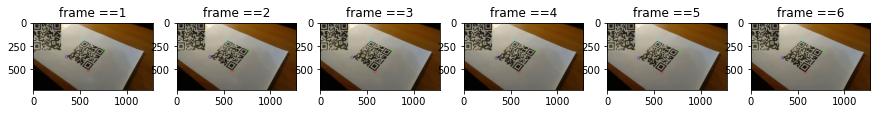

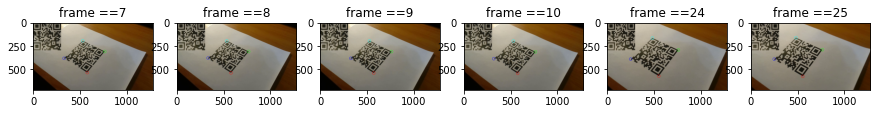

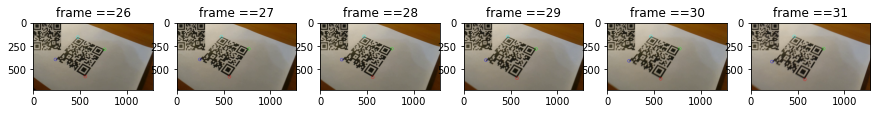

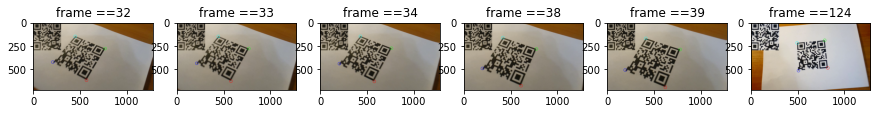

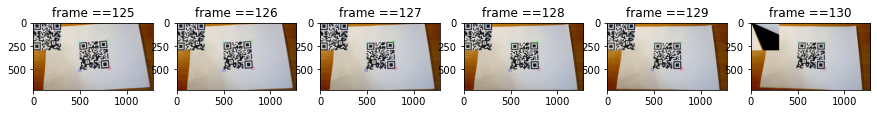

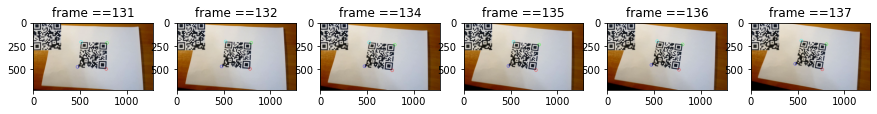

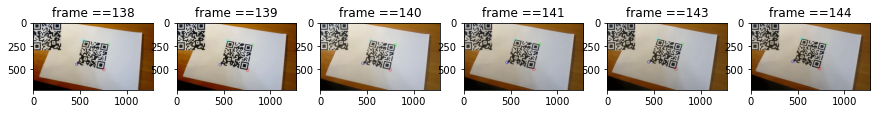

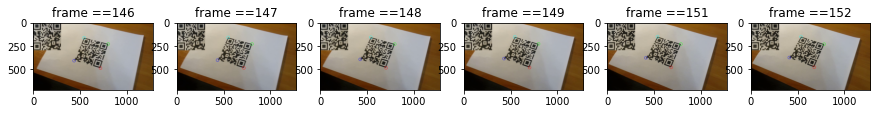

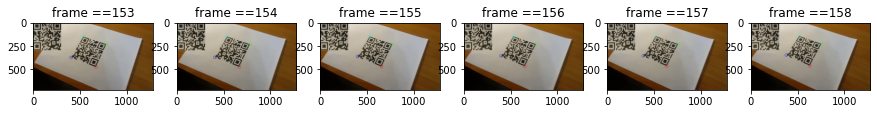

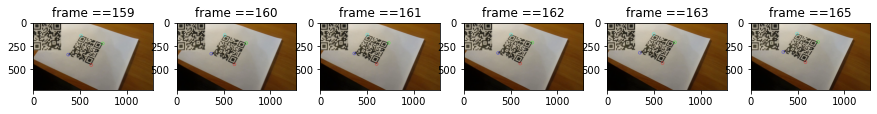

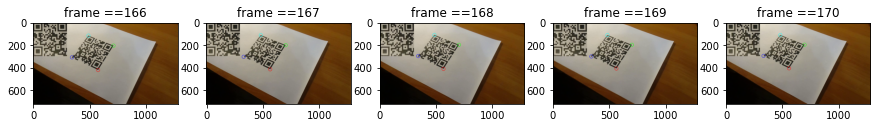

In [5]:
image_frames = []
count = 0
# Open a video with a QR code, find the QR code on each frame, 
# and, if successful, show the code corners 
# and un-warp the code to get a canonical view

cap = cv2.VideoCapture('../data/qr.mp4')
print('Created capture:', '../data/qr.mp4')
print('Frame count:', int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Frame width:', int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame rate:', cap.get(cv2.CAP_PROP_FPS))
    
while True:
    ret, frame = cap.read()
    if ret == False:
        break

    result, corners = qr_code_outer_corners(frame)
    count += 1
    
    qr_code_size = 300
    
    if result:
        if all((0, 0) < tuple(c) < (frame.shape[1], frame.shape[0]) for c in corners):
            rectified = rectify(frame, corners, (qr_code_size, qr_code_size))
            
            cv2.circle(frame, tuple(corners[0]), 15, (0, 255, 0), 2)
            cv2.circle(frame, tuple(corners[1]), 15, (0, 0, 255), 2)
            cv2.circle(frame, tuple(corners[2]), 15, (255, 0, 0), 2)
            cv2.circle(frame, tuple(corners[3]), 15, (255, 255, 0), 2)
            
            frame[0:qr_code_size, 0:qr_code_size] = rectified
            #################################################
            image_frames.append(["frame =={0}".format(count),frame[:,:,[2,1,0]]])
            ########=========================================
    cv2.imshow('QR code detection', frame)
    
    k = cv2.waitKey(100)
    
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

################################################
print("len(image_frames) ==", len(image_frames))
k =6
for i in range(0,len(image_frames),k):
    plt_view_image(plt,image_frames[i:i+k], figsize=(15,8), axis='on', cmap='gray')